# 5EL272 Systems and algorithms for Autonomous Vehicles
## Exercise 1: One-stage object detector
Created by Junjie Wang & Tomas Nordström, Umeå University

Revisions:
* 2024-10-28 First version /Junjie
* 2024-10-30 Commenting and cleaning up /Tomas
* 2024-11-20 Change to Keras 3.0, clean tensorflow, pytorch APIs /Junjie
* 2024-11-22 Complete Keras 3 version ready /Junjie
* 2024-11-22 Additional cleanup and commenting /Tomas
* 2024-11-25 More clean-up, adding questions, and removing solutions :-) /Tomas

**YOUR NAME**:

### Exercise Goals

In this lab, you will gain hands-on experience in building a single-stage object detector from the ground up. By completing this exercise, you will:

1. **Understand Object Detection Fundamentals**  
   Gain a foundational understanding of object detection principles, focusing on single-stage detection methods used in real-time applications.

2. **Explore and Implement Intersection over Union (IoU) Evaluation Metrics**  
   Learn how IoU is used to evaluate the accuracy of object detectors by measuring overlap between predicted and ground-truth bounding boxes.

3. **Implement and Utilize Anchor Boxes**  
   Generate and apply anchor boxes as a prior, learning how they serve as reference points for detecting objects of various sizes and aspect ratios.

4. **Implement and Apply Non-Maximum Suppression (NMS)**  
   Practice using NMS to filter overlapping bounding boxes, ensuring that the model outputs only the most confident predictions for each detected object.

For this lab, we will train a single-stage object detector on the **Penn-Fudan Database for Pedestrian Detection and Segmentation**, which contains 170 images with 345 annotated instances of pedestrians. This dataset will allow you to test and evaluate your detector in a practical context.

## Code summary

The code for this exercise consists of the following steps
1. Set up the dataset used Penn-Fudan Database for Pedestrian Detection and Segmentation **STUDENT CODE**
2. Helper functions to handle bounding boxes, like change formats (xyxy vs xywh) and plotting
3. Calculation of Intersection over Union (IoU) Evaluation Metrics **STUDENT CODE**
4. Generate anchor box priors, with varying scales (sizes) and aspect ratios (width-to-height proportions) **STUDENT CODE**
5. Function to match ground truth bounding boxes with anchors
6. Function to encode offset between ground truth bounding boxes with anchors (for training) **STUDENT CODE**
7. Function to convert database labels/targets to training labels (based on anchors)
8. Build a model (using transfer learning)
9. Define an object detection loss
10. Do the training
11. Do a prediction on unseen data
12. Implement a Non-Maximum Suppression function that can eliminate duplicate detections **STUDENT CODE**

There are also "**STUDENT Questions**" to look for!

As a bonus task we ask you to implement an mean Average Precision (mAP) evaluation

# First setting up the Python Environment

In [1]:
#### Set up tests to know if we are running Colab or Kaggle
import sys, os

### Is this notebook running on Colab?
IS_COLAB = "google.colab" in sys.modules

### Is this notebook running on Kaggle?
# Fool Kaggle into making kaggle_secrets avaiable
try:
    import kaggle_secrets
except ImportError as e:
    pass
# Now we can test for Kaggle
IS_KAGGLE = "kaggle_secrets" in sys.modules

In [2]:
# setup and import some libraries
import os
# we made the codes to be backend agnostic, you can switch between different backends
os.environ["KERAS_BACKEND"] = "tensorflow" # @param ["tensorflow", "jax", "torch"]

import keras
#print('Keras version:', keras.__version__)
import keras.ops as ops

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# General helper libs
import numpy as np
import time
import math
import json
import random
from scipy.special import softmax
import pandas as pd

# Image handlers
from skimage.io import imread
from PIL import Image
# Note that imgaug has problems with NumPy 2.0 (Colab is not there at the moment, but maybe for local environments)
# If you have problems you might need to manually patch "imgaug.py"
# I found it at ~/.venv/lib/python3.12/site-packages/imgaug/imgaug.py:45 but the crash gives exact path
# According to https://github.com/aleju/imgaug/issues/859
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

# Set up the Dataset
We are using [Penn-Fudan Database](https://www.cis.upenn.edu/~jshi/ped_html/) for Pedestrian Detection and Segmentation as our dataset for this exercise. This is an image database containing images that are used for pedestrian detection. There are 170 images with 345 labeled pedestrians, among which 96 images are taken from around University of Pennsylvania, and other 74 are taken from around Fudan University.

Also available [at Kaggle](https://www.kaggle.com/datasets/psvishnu/pennfudan-database-for-pedestrian-detection-zip)


In [3]:
# Define the datasets and some helper functions for managing the Penn-Fudan dataset
# Using https://keras.io/api/utils/python_utils/#pydataset-class
class PennFudanDataset(keras.utils.PyDataset):

    # URL of the Penn-Fudan pedestrian dataset
    url = "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"

    def download(self) -> None:
        """
        Downloads and extracts the dataset if not already downloaded.
        Ensures the extracted path is correctly set.
        """
        self.root = keras.utils.get_file(origin=self.url, extract=True)
        # Check if the extraction path is correct; adjust if necessary
        if not os.path.isdir(self.root):
            self.root = self.root.replace("PennFudanPed.zip", "")

    def __init__(self, batch_size=1, transforms=None, train=True, **kwargs):
        """
        Initialize the dataset.
        Args:
            batch_size (int): Number of samples per batch.
            transforms (callable): Optional data transformations.
            train (bool): Whether to use the training or testing split.
        """
        super().__init__(**kwargs)

        self.transforms = transforms  # Set any data transformations
        self.download()  # Ensure dataset is downloaded

        # Load and sort all images and masks for consistency
        imgs = list(sorted(os.listdir(os.path.join(self.root, "PennFudanPed/PNGImages"))))
        masks = list(sorted(os.listdir(os.path.join(self.root, "PennFudanPed/PedMasks"))))

        # Split the dataset into training and testing sets
        train_val_split = 0.8  # 80% for training, 20% for validation
        if train:
            self.imgs = imgs[: int(len(imgs) * train_val_split)]
            self.masks = masks[: int(len(imgs) * train_val_split)]
        else:
            self.imgs = imgs[int(len(imgs) * train_val_split):]
            self.masks = masks[int(len(imgs) * train_val_split):]

        self.batch_size = batch_size  # Store the batch size
        self.train = train  # Store whether it's training mode
        self.on_epoch_end()  # Shuffle data at the start

    def on_epoch_end(self):
        """
        Shuffle the dataset after each epoch if in training mode.
        """
        self.indexes = np.arange(len(self.imgs))  # Create an index array
        if self.train:
            np.random.shuffle(self.indexes)  # Shuffle the indices for randomness

    @staticmethod
    def masks_to_boxes(masks):
        """
        Compute the bounding boxes around the provided masks.

        Args:
            masks (Array[N, H, W]): Array of masks where N is the number of masks,
                and H and W are the spatial dimensions.

        Returns:
            Array[N, 4]: Bounding boxes in [x_min, y_min, x_max, y_max] format.
        """
        if masks.itemsize == 0:  # Return empty array if no masks
            return np.zeros((0, 4), dtype=float)

        n = masks.shape[0]  # Number of masks
        bounding_boxes = np.zeros((n, 4), dtype=float)  # Initialize bounding boxes array

        for index, mask in enumerate(masks):  # Iterate through each mask
            y, x = np.where(mask != 0)  # Find non-zero pixels (mask region)

            # Set bounding box coordinates
            bounding_boxes[index, 0] = np.min(x)
            bounding_boxes[index, 1] = np.min(y)
            bounding_boxes[index, 2] = np.max(x)
            bounding_boxes[index, 3] = np.max(y)

        return bounding_boxes  # Return computed bounding boxes

    def __getitem__(self, index):
        """
        Retrieve a batch of data.

        Args:
            index (int): Index of the batch.

        Returns:
            Tuple: A batch of images and their corresponding targets.
        """
        # Get the indices for the batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        #  individual samples and store in batch
        batches = [self.featch_single(k) for k in indexes]

        # Prepare batch outputs
        img_l = []  # List of images
        target_l = []  # List of target dictionaries

        for img, target in batches:  # Process each batch
            img_l.append(img[None, :, :, :])  # Add image to batch
            # Concatenate labels and bounding boxes
            target = np.concatenate([target['labels'][:, None], target['boxes']], axis=1)
            target_l.append(target)

        # Combine all images into a single batch
        img_l = np.concatenate(img_l, axis=0)
        return img_l, target_l  # Return images and targets

    def featch_single(self, idx):
        """
         a single data sample by index.

        Args:
            idx (int): Index of the sample.

        Returns:
            Tuple: Image and its target (bounding boxes and labels).
        """
        # Load the image and mask file paths
        img_path = os.path.join(self.root, "PennFudanPed/PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PennFudanPed/PedMasks", self.masks[idx])
        img = imread(img_path)  # Load image as array
        mask = imread(mask_path)  # Load mask as array

        # Get unique object IDs (colors in mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]  # Remove the background (first ID)
        num_objs = len(obj_ids)  # Number of objects

        # Generate binary masks for each object
        masks = (mask == obj_ids[:, None, None]).astype(np.uint8)

        # Compute bounding boxes for each object
        boxes = self.masks_to_boxes(masks)  # Convert masks to bounding boxes

        # Wrap bounding boxes for augmentation purposes
        boxes = BoundingBoxesOnImage.from_xyxy_array(boxes, img.shape)

        # Assign a single class label (e.g., "pedestrian")
        labels = np.ones((num_objs,), dtype=np.int64)

        # Apply transformations if provided
        if self.transforms is not None:
            img, boxes = self.transforms(image=img, bounding_boxes=boxes)

        # Prepare the target dictionary
        target = {}
        target['boxes'] = boxes.to_xyxy_array()  # Convert bounding boxes back to array
        target['labels'] = labels  # Add labels
        return img, target  # Return image and target


    def no_data_elements(self):
        """
        Return the total number of images.
        Returns:
            int: Number of images.
        """
        ##################### YOUR CODE STARTS HERE ###################
        
        noelems = len(self.imgs)
        ##################### YOUR CODE ENDS HERE #####################

        return noelems

    def __len__(self):
        """
        Return the total number of batches.

        Returns:
            int: Number of batches.
        """
        return len(self.imgs) // self.batch_size  # Compute number of batches

In [4]:
# Now get the dataset to test your no_data_elements function
PF_dataset = PennFudanDataset(train=True)
noelems = PF_dataset.no_data_elements()
print(noelems)
assert np.allclose(noelems, 136), f"There is something wrong with the implementation no_data_elements, please try again."
print(f'We have {noelems} images.')


136
We have 136 images.


# Helper Functions for Bounding Boxes

In [6]:
def box_corner_to_center(boxes):
    """Convert bounding boxes from (upper-left, lower-right) to (center, width, height) format.
    Args:
        boxes (ndarray): Bounding boxes in (x_min, y_min, x_max, y_max) format, shape (N, 4).
    Returns:
        ndarray: Converted bounding boxes in (center_x, center_y, width, height) format, shape (N, 4).
    """

    # Separate the coordinates of the upper-left and lower-right corners
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]

    # Calculate the center x and y coordinates as the midpoint between x1, x2 and y1, y2
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2

    # Calculate the width and height of the bounding boxes
    w = x2 - x1
    h = y2 - y1

    # Stack the center coordinates and size (width, height) into a new tensor
    boxes = np.stack((cx, cy, w, h), axis=-1)

    return boxes  # Bounding boxes in (center_x, center_y, width, height) format


def box_center_to_corner(boxes):
    """Convert bounding boxes from (center, width, height) to (upper-left, lower-right) format.
    Args:
        boxes (ndarray): Bounding boxes in (center_x, center_y, width, height) format, shape (N, 4).
    Returns:
        ndarray: Converted bounding boxes in (x_min, y_min, x_max, y_max) format, shape (N, 4).
    """

    # Separate the center coordinates and width/height of each bounding box
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]

    # Calculate the x and y coordinates of the upper-left corner
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h

    # Calculate the x and y coordinates of the lower-right corner
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h

    # Stack the corner coordinates into a new tensor
    boxes = np.stack((x1, y1, x2, y2), axis=-1)

    return boxes  # Bounding boxes in (x_min, y_min, x_max, y_max) format

def bbox_to_rect(bbox, color):
    """Convert a bounding box to a format compatible with matplotlib's Rectangle.
    Args:
        bbox (tuple or list): Bounding box in the format (upper-left x, upper-left y, lower-right x, lower-right y).
        color (str or tuple): Color for the rectangle's edge.
    Returns:
        matplotlib.patches.Rectangle: A rectangle patch representing the bounding box, formatted for display with matplotlib.
    """

    width = bbox[2] - bbox[0]  # Lower-right x - upper-left x
    height = bbox[3] - bbox[1]  # Lower-right y - upper-left y

    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=width, height=height,
        fill=False, edgecolor=color, linewidth=1
    )

def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Display bounding boxes on a given set of axes.
    Args:
        axes (matplotlib.axes.Axes): The axes on which to draw the bounding boxes.
        bboxes : Tensor of bounding boxes in the format (x1, y1, x2, y2).
        labels : Optional list of labels for each bounding box.
        colors (list or tuple, optional): Optional list of colors for each bounding box.
    """

    # Helper function to ensure input is in list format or provide default values
    def make_list(obj, default_values=None):
        # If no object is provided, use default values
        if obj is None:
            obj = default_values
        # If the object is a single item (not a list or tuple), convert it to a list
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    # Ensure labels is a list (or None if no labels are given)
    labels = make_list(labels)

    # Set default colors if colors are not provided, cycling through ['b', 'g', 'r', 'm', 'c']
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])

    # Iterate over each bounding box
    for i, bbox in enumerate(bboxes):
        # Select a color for each bounding box, cycling if there are more boxes than colors
        color = colors[i % len(colors)]

        # Convert bounding box to matplotlib's Rectangle format and specify the color
        rect = bbox_to_rect(bbox, color)

        # Add the rectangle to the axes
        axes.add_patch(rect)

        # If labels are provided and available for this box, add a text label
        if labels and len(labels) > i:
            # Choose text color to ensure contrast with the bounding box color
            text_color = 'k' if color == 'w' else 'w'

            # Add text annotation at the top-left corner of the bounding box
            axes.text(
                rect.xy[0], rect.xy[1],  # Position of the text
                labels[i],               # Text label
                va='center', ha='center',  # Center alignment
                fontsize=9, color=text_color,  # Font settings
                bbox=dict(facecolor=color, lw=0)  # Background box with the same color as the rectangle
            )

##  Now we can visualize a sample data to see what the dataset looks like.

Image shape = (378, 490, 3)
Number of target boxes =  3


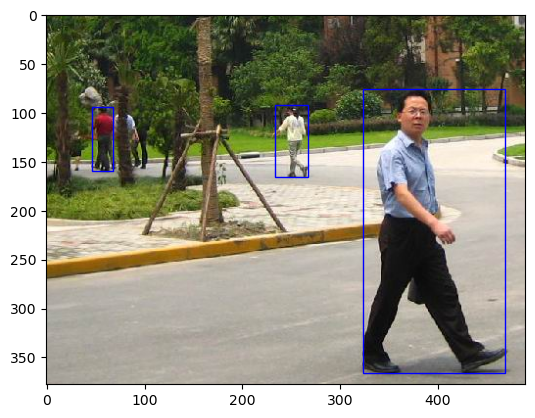

In [7]:
dataset_vis = PennFudanDataset()
img, target = dataset_vis.featch_single(20)
fig = plt.imshow(img)
for box in target['boxes']:
    fig.axes.add_patch(bbox_to_rect(box, 'blue'))
# Additional info
print(f'Image shape = {img.shape}')
print('Number of target boxes = ' , len(target['boxes']))

# Calculation of IOU

IoU is the ratio of the intersection area to the union area of two bounding boxes. And will be used as a measure of box to box alignement

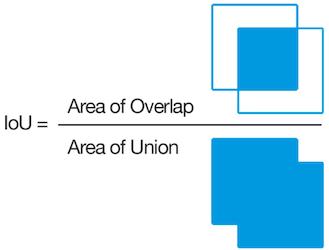

## Define support functions to calculate IoU between two boxes.

In [19]:
def box_iou(box1, box2):
    """Compute the Intersection over Union (IoU) for a pair of bounding boxes.
    Args:
        box1 (ndarray): Coordinates of the first bounding box, format [x_min, y_min, x_max, y_max].
        box2 (ndarray): Coordinates of the second bounding box, format [x_min, y_min, x_max, y_max].
    Returns:
        float: The IoU between `box1` and `box2`.
    """
 
    ##################### YOUR CODE STARTS HERE ###################
    
    # topleft cordinates of box = (x_min,y_min)
    # bottomright cordinates of box = (x_max,y_max)
    x1_min, y1_min, x1_max, y1_max = box1[0], box1[1], box1[2], box1[3]
    x2_min, y2_min, x2_max, y2_max = box2[0], box2[1], box2[2], box2[3]
    
    box1_hight = max(y1_max - y1_min,0)
    box1_width  = max(x1_max - x1_min,0)
    
    box2_hight = max(y2_max - y2_min,0)
    box2_width  = max(x2_max - x2_min,0)
    
    Area_Box1 = box1_hight * box1_width
    Area_Box2 = box2_hight * box2_width
    
    # Calculate coordinates of the intersection box
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)
    
    inter_height = max(inter_x_max - inter_x_min,0)
    inter_width  = max(inter_y_max - inter_y_min,0)
   
    # intersection  = AnB = Area of Overlap between Box1 and Box2 
    intersection = inter_height * inter_width
    
    # Area_Of_Union =  Area of Box1 + Area of Box2 - Area of Intersection
    Area_Of_Union = Area_Box1 + Area_Box2 - intersection
     
    # Intersection Over Unit =  AnB / AUB = intersection / Area_Of_Union
    iou = intersection / Area_Of_Union if Area_Of_Union !=0 else 0
    ##################### YOUR CODE ENDS HERE #####################

    return iou

def box_iou_batch(boxes1_batch, boxes2_batch):
    """Compute pairwise IoU for two lists (batches) of bounding boxes.
    Args:
        boxes1_batch (ndarray): A batch of bounding boxes, shape (N, 4).
        boxes2_batch (ndarray): A second batch of bounding boxes, shape (M, 4).
    Returns:
        ndarray: Matrix of IoUs, shape (N, M), with IoU values between each pair of boxes.
    """

    # Initialize an (N, M) IoU matrix to store IoU values between every pair of boxes
    iou_b = np.zeros((boxes1_batch.shape[0], boxes2_batch.shape[0]))

    # Iterate through each box in boxes1_batch and boxes2_batch to compute pairwise IoU
    for i, boxes1 in enumerate(boxes1_batch):
        for j, boxes2 in enumerate(boxes2_batch):
            iou_b[i, j] = box_iou(boxes1, boxes2)  # Compute IoU for each pair and store in matrix

    return iou_b

Test your implementation

In [21]:
test_cases = [
    np.array([[ 20.,   3., 107., 124.], [125., 92., 211., 365.]]),
    np.array([[148.,   3., 235., 124.], [203.,  80., 321., 366.]]),
    np.array([[134.,  18., 249., 109.], [125.,  92., 211., 362.]])
]
gt_results = np.array([0.        , 0.03284578, 0.04043118])

test_result = np.array([box_iou(case[0], case[1]) for case in test_cases ])
assert np.allclose(test_result, gt_results), f"There is something wrong with your box_iou implementation, please try again."

# Generate Anchor Box Priors

## Introduction
Anchor boxes are fixed sized boxes that the model uses to predict the bounding box for an object. It does this by regressing the offset between the location of the object's center and the center of an anchor box, and then uses the width and height of the anchor box to predict a relative scale of the object.

In this exercise we set anchor box size to 32x32 and therefore we for example
with an image size 391x492 get a grid shape 12x15. For the model we are going to train later we restrict the image size to 224x224 and therefore will use a a grid shape of 7x7.

### Overview
Anchor boxes are predefined bounding boxes with different sizes and aspect ratios that are centered at each position in a feature map of shape $h \times w $. These boxes provide a set of initial "guesses" for object locations, allowing the model to adjust and refine them during training.

### Calculation Details
Each anchor box is defined by a scale $s$ (relative to the grid size) and an aspect ratio $ r > 0 $ (width-to-height ratio). Using these values:
- The relative height of the anchor box is calculated as $s \times  \sqrt{r} $
- The relative width of the anchor box is $ s / \sqrt{r} $

### Output
For each anchor box, we return the four relative coordinates $[x_{\text{min}}, y_{\text{min}}, x_{\text{max}}, y_{\text{max}}]$ representing the box's corners (but note that this is in box-grid coordinates and not pixel coordinates). This format allows us to easily place and scale anchor boxes across the feature map grid.

In [22]:
def generate_anchor_boxes(input_shape, scale_and_ratio):
    """Generate anchor boxes of various shapes centered at each grid element/box in the input image.
    Args:
        input_shape (tuple): Height and width of the grid (e.g., (height, width)).
        scale_and_ratio (list): List of tuples, each containing a scale and aspect ratio,
                                e.g., [(scale0, ratio0), (scale1, ratio1), ...].
                                The scale and ratio is in relation to a normalized grid box
    Returns:
        ndarray: shape (height, width, num_anchor_boxes, 4), containing the coordinates
                      of anchor boxes centered on each grid element of the input.
    """

    in_height, in_width = input_shape

    # Define offsets to place anchors centered at each grid element
    offset_h, offset_w = 0.5, 0.5

    # Generate the y and x coordinates for all center points in the input feature map
    center_h = np.arange(in_height) + offset_h
    center_w = np.arange(in_width) + offset_w

    # Use meshgrid to create 2D grids of center y and x coordinates
    shift_y, shift_x = np.meshgrid(center_h, center_w, indexing='ij')

    # Create a (height*width, 4) tensor where each row represents the same center (x, y) coordinates twice
    # This format (x1, y1, x2, y2) prepares for coordinate shifts based on box dimensions
    centers_shift = np.concatenate(
        [shift_x.reshape(-1, 1), shift_y.reshape(-1, 1),
         shift_x.reshape(-1, 1), shift_y.reshape(-1, 1)],
        axis=1
    )  # Shape: (height*width, 4)

    # List to store anchor box dimensions for each (scale, ratio) pair
    anchor_boxes = []
    for scale, ratio in scale_and_ratio:
        # Calculate anchor box height and width for the given scale and aspect ratio
        # Height is scaled by s * sqrt(r) and width by s / sqrt(r), where: s is the scale, and r is the aspect ratio

        ##################### YOUR CODE STARTS HERE #####################
        h = scale * np.sqrt(ratio)
        w = scale / np.sqrt(ratio)
        ##################### YOUR CODE ENDS HERE ######################

        # Append the anchor box coordinates as offsets from the center (x1, y1, x2, y2)
        anchor_boxes.append((-w / 2, -h / 2, w / 2, h / 2))

    # Convert the list of anchor boxes to a tensor of shape (num_anchor_boxes, 4)
    n_anchor_boxes = len(anchor_boxes)
    anchor_boxes = np.array(anchor_boxes)  # Shape: (num_anchor_boxes, 4)

    # Expand the centers tensor by repeating for each anchor box type, creating (height*width, num_anchor_boxes, 4)
    centers_shift = centers_shift[:, None, :].repeat( n_anchor_boxes, axis=1)

    # Add the offset centers to each anchor box to get absolute coordinates of all anchor boxes
    anchor_boxes_all = centers_shift + anchor_boxes

    # Reshape to (height, width, num_anchor_boxes, 4) for final output
    return anchor_boxes_all.reshape((in_height, in_width, n_anchor_boxes, 4))


###  Now we can try to visualize some of the generated anchor boxes

Implement your codes above section. When set scale_and_ratio [(5, 1), (5, 2), (5, 0.5)], the anchor boxes should look like this,

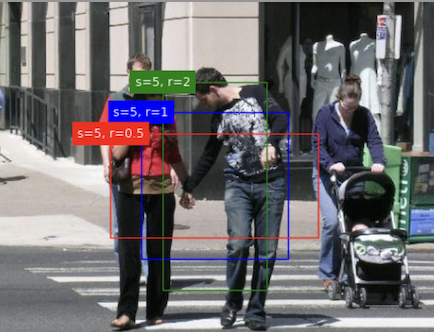

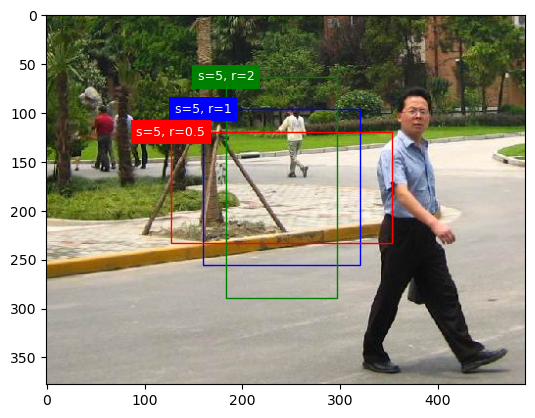

In [31]:
# Visualize the set of achorboxes for one particular grid point

# We divide the whole image into gridboxes of size grid_size x grid_size (32x32)
# and then create our achorboxes at the center of each gridbox
grid_size = 32 # Set the grid size for anchor boxes

# Define scales and aspect ratios for generating anchor boxes
# Each tuple (scale, aspect_ratio) defines the size and shape of anchor boxes in relation to grid_size
# For visualisation purpose we now set the scale to 5 even if we later will set it to be even less than 1 (like 0.8)
#scale_and_ratio = [(5, 1), (5, 2), (5, 0.5)]  # scale=5, aspect_ratios=1, 2, and 0.5
scale_and_ratio = [(5, 1), (5, 2), (5, 0.5)]  # scale=5, aspect_ratios=1, 2, and 0.5
# Generate a set of anchor boxes based on the grid shape (original image dimensions divided by the grid size)
anchor_boxes = generate_anchor_boxes((img.shape[0] // grid_size, img.shape[1] // grid_size), scale_and_ratio)

# Display the original image for visualizing the anchor boxes on it
fig = plt.imshow(img)

# Select the anchor boxes centered at a specific grid location (middle of the image)
# Multiply by grid_size to scale anchor boxes to the original image dimensions
# Labels for the anchor boxes indicate the scale and aspect ratio
show_bboxes(
    fig.axes,
    anchor_boxes[img.shape[0] // (grid_size * 2), img.shape[1] // (grid_size * 2), :, :] * grid_size,
    ['s=5, r=1', 's=5, r=2', 's=5, r=0.5']
)

In [26]:
# Print some of the shapes and values
print(f'Input image shape {img.shape}')
print(f'Grid shape {(img.shape[0] // grid_size, img.shape[1] // grid_size)}')
print(f'Anchor box shape {anchor_boxes.shape}')
print(f'Grid index we plot {(img.shape[0] // (grid_size * 2), img.shape[1] // (grid_size * 2))}')
print(f'Coordinates of achorboxes at the selected grid index\n {anchor_boxes[6,7,:]}')

Input image shape (378, 490, 3)
Grid shape (11, 15)
Anchor box shape (11, 15, 3, 4)
Grid index we plot (5, 7)
Coordinates of achorboxes at the selected grid index
 [[ 5.          4.         10.          9.        ]
 [ 5.73223305  2.96446609  9.26776695 10.03553391]
 [ 3.96446609  4.73223305 11.03553391  8.26776695]]


STUDENT Question:
* As scale is just set for visualization, you can not deduct much about scale from this visualization. But what seems as a good ratio for when we are detecting pedestrians?


YOUR Answer:After looking at the image and the anchor boxes a good ratio looks to be when R=2 as pedestrian is higher then their width as the green plotted anchor box in image, 

# Assigning Ground-Truth Bounding Boxes to Anchor Boxes based on the highest IoU

## Assign each ground-truth bounding box to an anchor box.
In the following code, we only assign one ground-truth bounding box to one anchor box based on the highest IoU score.

Actually, we can assign one ground-truth bounding box to multiple anchor boxes when the IoU is greater than a threshold (e.g. 0.5).

In [33]:
def assign_anchor_to_bbox(ground_truth, anchors, iou_threshold=0.5):
    """Assign the closest ground-truth bounding box to each anchor box,
    given a large enough iou value.
    Args:
        ground_truth : ndarray containing the ground-truth bounding boxes.
        anchors : ndarray containing the anchor boxes.
        iou_threshold : IoU threshold to determine if an anchor is assigned a ground-truth box.
    Returns:
        A ndarray of assigned ground-truth box indices for each anchor box.
        -1 indicates no assignment.
    """

    # Determine the number of anchors and ground-truth boxes
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]

    # Calculate the IoU (Intersection over Union) aka as Jaccard index between each anchor and each ground-truth box
    # Resulting in a matrix where each element x_ij is the IoU of anchor i with ground-truth box j
    jaccard = box_iou_batch(anchors, ground_truth)

    # Initialize a map to store the assigned ground-truth box index for each anchor
    # -1 indicates that no ground-truth box has been assigned to the anchor
    anchors_bbox_map = np.full((num_anchors,), -1, dtype=np.int64)

    # Find the maximum IoU and corresponding ground-truth box index for each anchor
    indices = np.argmax(jaccard, axis=1)
    max_ious = np.max(jaccard, axis=1)

    # Select anchors where the maximum IoU exceeds the threshold
    anc_i = np.flatnonzero(max_ious >= iou_threshold)

    # Get the indices of the ground-truth boxes assigned to those anchors
    box_j = indices[max_ious >= iou_threshold]

    # Assign the selected ground-truth boxes to the anchors that passed the IoU threshold
    anchors_bbox_map[anc_i] = box_j

    # Prepare "discard" tensors to mark columns (ground-truth boxes) and rows (anchors) that are processed
    col_discard = np.full((num_anchors,), -1)
    row_discard = np.full((num_gt_boxes,), -1)

    # Loop over ground-truth boxes to ensure that each ground-truth box is assigned at least one anchor
    for _ in range(num_gt_boxes):
        # Find the index of the highest IoU in the matrix
        max_idx = np.argmax(jaccard)

        # Calculate the row (anchor index) and column (ground-truth box index) corresponding to max IoU
        box_idx = (max_idx % num_gt_boxes).astype(np.int64)
        anc_idx = (max_idx / num_gt_boxes).astype(np.int64)

        # Assign this ground-truth box to the selected anchor
        anchors_bbox_map[anc_idx] = box_idx

        # Discard this ground-truth box and anchor by setting their IoU values to -1, so they are not reused
        jaccard[:, box_idx] = col_discard  # Discard the selected ground-truth box column
        jaccard[anc_idx, :] = row_discard  # Discard the selected anchor row

    # Return the mapping of ground-truth boxes assigned to each anchor
    return anchors_bbox_map


##  Let's see our image and the assigned anchor boxes

Text(0.5, 0, 'The hinted anchor boxes')

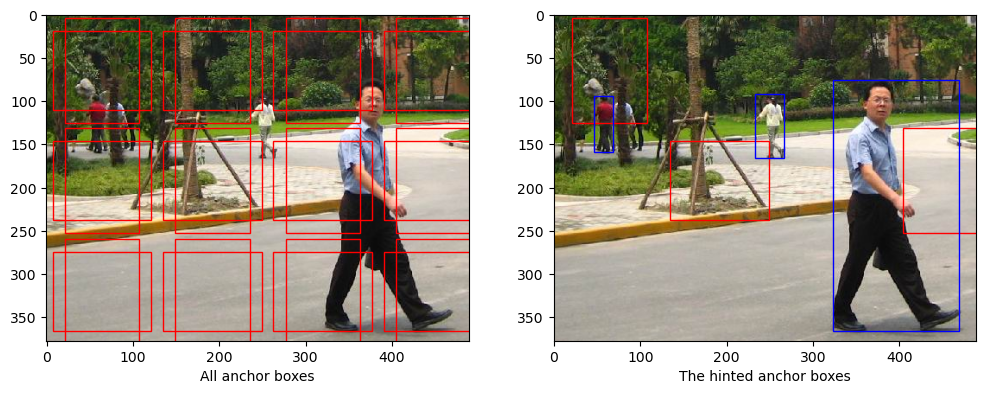

In [34]:
# Retrieve ground-truth bounding boxes from the target data
# gt_boxes has shape (N, 4), where N is the number of ground-truth boxes
gt_boxes = target['boxes']  # Shape: (N, 4)

# Define scales and aspect ratios for generating anchor boxes
scale_and_ratio = [(0.8, 1.4), (0.8, 0.8)]

# Generate anchor boxes based on image dimensions (scaled down by 128)
# img.height//128+1 and img.width//128+1 calculate the grid size in the feature map
# The resulting anchor_boxes tensor has shape (feature map height, feature map width, num_scales, 4)
anchor_boxes = generate_anchor_boxes((img.shape[0] // 128 + 1, img.shape[1] // 128 + 1), scale_and_ratio)

# Flatten the anchor boxes tensor into shape (-1, 4) and scale back up by 128
# to match the original image dimensions
anchor_boxes = anchor_boxes.reshape(-1, 4) * 128  # Shape: (num_anchor_boxes, 4)

# Assign each anchor box to the closest ground-truth box using IoU thresholding
# 'assigned' will contain indices of ground-truth boxes assigned to each anchor box
assigned = assign_anchor_to_bbox(gt_boxes, anchor_boxes)

# Create a mask of anchor boxes that are successfully assigned to a ground-truth box
# 'assigned_index' will be a boolean array, with True for assigned anchors and False otherwise
assigned_index = assigned >= 0

# Set up two subplots side-by-side to visualize all anchor boxes and the assigned ones
fig, axes = plt.subplots(1, 2, figsize=(12, 12))

# Display the original image in both subplots
axes[0].imshow(img)
axes[1].imshow(img)

# Display all generated anchor boxes in the first subplot with red borders
show_bboxes(axes[0], anchor_boxes, colors=['r'])
axes[0].set_xlabel('All anchor boxes')

# Display only the assigned anchor boxes in the second subplot
# Assigned anchor boxes are shown in red, ground-truth boxes in blue
show_bboxes(axes[1], anchor_boxes[assigned_index], colors=['r'])
show_bboxes(axes[1], gt_boxes, colors=['b'])
axes[1].set_xlabel('The hinted anchor boxes')


# Encode/decode the grounding truth boxes

We now have both the anchor box and its corresponding assigned bounding box.

To encode the bounding box, we need to calculate its relative position and size compared to the anchor.

Example:

Given:

- Anchor box: [x_center_anc, y_center_anc, w_anc, h_anc]
- Assigned bounding box: [x_center, y_center, w, h]

The encoded values are calculated as follows:

- Encoded x-coordinate: (x_center - x_center_anc) / w_anc
- Encoded y-coordinate: (y_center - y_center_anc) / h_anc
- Encoded width: log(w / w_anc)
- Encoded height: log(h / h_anc)


In [35]:
def encode_boxes(anchors, assigned_bb):
    """Encode the bounding boxes with respect to anchor boxes for training.
    Args:
        anchors (array): Anchor boxes, shape (N, 4), defined by 4 corner coordinates.
        assigned_bb (array): Ground-truth bounding boxes assigned to each anchor, shape (N, 4),
                                    with padding of zeros for unassigned anchors.
    Returns:
        array: Encoded bounding box offsets, shape (N, 4).
    """
    # Convert anchor boxes and ground-truth bounding boxes from corner format to center format
    # Center format: (center_x, center_y, width, height)
    c_anchor = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    ##################### YOUR CODE STARTS HERE ###################
    x_center_anc, y_center_anc, w_anc, h_anc = c_anchor[:,0], c_anchor[:,1], c_anchor[:,2], c_anchor[:,3]
    x_center, y_center, w, h = c_assigned_bb[:,0], c_assigned_bb[:,1], c_assigned_bb[:,2], c_assigned_bb[:,3]
    # Calculate the normalized offsets for the x and y center coordinates
    norm_offset_x = (x_center - x_center_anc) / w_anc
    norm_offset_y = (y_center - y_center_anc) / h_anc
    # Calculate the normalized offsets for the width and height using logarithmic scale
    norm_offset_w = np.log(w / w_anc)
    norm_offset_h = np.log(h / h_anc)
    # Concatenate the offsets for (x, y) and (width, height) to form the final encoded offsets
    offset = np.stack((norm_offset_x, norm_offset_y, norm_offset_w, norm_offset_h), axis=-1)

    ##################### YOUR CODE ENDS HERE #####################
    return offset  # Encoded offsets for bounding boxes relative to the anchors


def decode_boxes(anchors, offset_preds):
    """Decode the predicted offsets to actual bounding box coordinates.
    Args:
        anchors (array): Anchor boxes, shape (N, 4), defined by 4 corner coordinates.
        offset_preds (array): Predicted offsets for each anchor, shape (N, 4).
    Returns:
        Decoded bounding boxes in corner format, shape (N, 4).
    """
    # Convert anchor boxes from corner format to center format
    # Center format: (center_x, center_y, width, height)
    anc = box_corner_to_center(anchors)
    ##################### YOUR CODE STARTS HERE ###################
    # Decode the center coordinates (x, y) from the predicted offsets
    # Decode the width and height from the predicted offsets using exponential scale
    # Combine the decoded center coordinates and dimensions to get the box in center format

    ##################### YOUR CODE ENDS HERE #####################
    # Convert the bounding boxes back to corner format (x_min, y_min, x_max, y_max)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox  # Decoded bounding boxes in (x_min, y_min, x_max, y_max) format

In [36]:
# Check the implemetation

anchors = np.array([[148.,   3., 235., 124.], [134.,  18., 249., 109.]])
bboxing = np.array([[203.,  80., 321., 366.], [125.,  92., 211., 362.]])

encoded = encode_boxes(anchors, bboxing)

decoded_boxes = decode_boxes(anchors, encoded)
print(f"encoded boxes: {encoded}")
assert np.allclose(bboxing, decoded_boxes), f"There is something wrong with your encode_boxes or decode_boxes implementation, please try again."


NameError: name 'pred_bbox' is not defined

STUDENT Question:
* Why do we need to encode/decode the bounding boxes?

YOUR Answer:

# Generate multi-box targets



We've implemented ***assign_anchor_to_bbox*** to assign each ground truth box to a specific anchor box and ***encode_boxes*** to encode the ground truth boxes into a format suitable for training.

Now we need to put them togeter to **generate_multibox_targets** ready for the neural network.

For anchor boxes that are not assigned to any ground truth box, their associated bounding box regression targets can be ignored, as they are not relevant to the training process.

In [ ]:
def generate_multibox_target(anchors, labels):
    """ Generate a batch of target tuples,
    based on anchor boxes and a batch of ground-truth labels (ground-truth bounding boxes and class labels).
    Args:
        anchors (array): array containing anchor boxes.
        labels (array): array of ground-truth labels (a batch), with GT class and GT bounding box coordinates.
    Returns:
        tuple: (bbox_offset, bbox_mask, class_labels) where:
            - bbox_offset: Encoded offsets for each anchor relative to assigned ground-truth boxes.
            - bbox_mask: Mask to indicate valid anchor assignments for loss calculation.
            - class_labels: Class labels for each anchor, with 0 as the background class.
    """

    # Determine batch size and reshape anchors for use in batch operations
    batch_size = len(labels)

    # Initialize lists to store the target offsets, masks, and class labels for each batch
    batch_offset, batch_mask, batch_class_labels = [], [], []

    num_anchors = anchors.shape[0]

    for i in range(batch_size):
        # Extract the labels for the i-th image, containing classes and bounding box coordinates
        label = labels[i]

        # Map each anchor to the closest ground-truth box, using IoU thresholding
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors) # n_anchor_boxes

        # Create a mask for assigned anchors: 1 if assigned, 0 otherwise
        # bbox_mask = (anchors_bbox_map >= 0).astype(np.float64)[:,None].repeat(4, axis=1)
        bbox_mask = (anchors_bbox_map >= 0).astype(np.float64)

        # Initialize class labels and bounding box assignments to zero (background class)
        class_labels = np.zeros(num_anchors, dtype=np.int64)
        assigned_bb = np.zeros((num_anchors, 4), dtype=np.float32)

        # Find indices of anchors assigned to ground-truth boxes
        indices_true = np.where(anchors_bbox_map >= 0)

        # Retrieve indices of assigned ground-truth boxes for these anchors
        bb_idx = anchors_bbox_map[indices_true]

        # Set class labels for assigned anchors based on ground-truth box classes
        # Label 0 is for background; other values correspond to object classes
        class_labels[indices_true] = label[bb_idx, 0]

        # Assign the corresponding ground-truth box coordinates to these anchors
        assigned_bb[indices_true] = label[bb_idx, 1:]

        # Apply an encoding transformation to get offsets between anchors and assigned boxes
        # Offsets are masked with bbox_mask to ignore non-assigned anchors in loss calculations
        offset = encode_boxes(anchors, assigned_bb) * bbox_mask[:,None].repeat(4, axis=1)

        batch_offset.append(offset)
        batch_mask.append(bbox_mask)
        batch_class_labels.append(class_labels)

    # Stack results for each batch to return as tensors
    bbox_offset = np.stack(batch_offset)  # Encoded offsets for each anchor
    bbox_mask = np.stack(batch_mask)      # Mask to indicate assigned anchors
    class_labels = np.stack(batch_class_labels)  # Class labels for each anchor

    return (bbox_offset, bbox_mask, class_labels)

# adding the generate_multibox_target and function
class PennFudanDatasetWithMultiboxTarget(PennFudanDataset):

    def __init__(self, scale_and_ratio, batch_size=1, transforms=None, train=True):
        super().__init__(batch_size, transforms, train)
        anchor_boxes = generate_anchor_boxes( (7, 7), scale_and_ratio)
        self.anchors = anchor_boxes.reshape(-1, 4) * 32

    def __getitem__(self, index):
        img_l, target_l = super().__getitem__(index)
        bbox_labels, bbox_masks, cls_labels = generate_multibox_target(self.anchors, target_l)
        # for better compatible with keras 3, concatnate into one tensor,
        cls_labels[bbox_masks < 1] = 0
        return img_l, np.concatenate( (bbox_labels, cls_labels[:, :, None]), axis=-1)


## Now, let's build a detection model

In [ ]:
# First look at the backbone seperately
backbone = keras.applications.ResNet50(
            include_top=False, input_shape=[224, 224, 3]
        )

backbone.summary(show_trainable=True, line_length=100)

STUDENT Questions:
* How many features are in the output of this model (that is, after the last layer conv5_block3_out)?
* If you would like to turn of training of the transfered part of the model, what is the command/method to do that on a Keras model/layer?

YOUR Answer:
*
*

In [ ]:
# Define a detector model
#   Backbone = ResNet50 up until conv5_block3_out (2048 features)
#   Outputs (cls_predictor & bbox_predictor) * num_anchors
class Detector(keras.Model):
    def __init__(self, num_anchors, num_classes, **kwargs):
        """Initialize the Detector model with base model, feature extractors, and anchor box predictors.
        Args:
            num_anchors (int): Number of anchor boxes per feature map location.
            num_classes (int): Number of object classes to predict.
        """
        super(Detector, self).__init__(**kwargs)

        # Builds ResNet50 with pre-trained imagenet weights
        backbone = keras.applications.ResNet50(
            include_top=False, input_shape=[None, None, 3]
        )

        c5_output = backbone.get_layer("conv5_block3_out").output # With 224x224 input, we have 7x7x2048 parameters here

        self.base_model = keras.Model(
            inputs=[backbone.inputs], outputs=[c5_output]
        )

        self.num_classes = num_classes
        self.cls_predictor = keras.layers.Conv2D(num_anchors * (num_classes + 1), 1, 1) # Note 1x1 kernels
        self.bbox_predictor = keras.layers.Conv2D(num_anchors * 4, 1, 1)

    def call(self, x):
        """Forward pass through the model to extract features, generate anchor boxes, and make predictions.
        Args:
            x (tensor): Input image tensor.
        Returns:
            Tuple[Tensor, Tensor, Tensor]:
                - Anchor boxes tensor.
                - Classification predictions for each anchor.
                - Bounding box predictions for each anchor.
        """

        features = self.base_model(x) # 2048
        cls_preds = self.cls_predictor(features)
        bbox_preds = self.bbox_predictor(features)

        # for better keras 3 support, concatenate into one tensor
        b = ops.shape(features)[0]
        cls_preds = ops.reshape(cls_preds, (b, -1, self.num_classes + 1)) # b, h, w, num_anchors * (num_classes + 1) --> b, h*w*num_anchors, (num_classes + 1)
        bbox_preds = ops.reshape(bbox_preds, (b, -1, 4)) # b, h, w, num_anchors * 4 --> b, h*w*num_anchors, 4

        return ops.concatenate( (bbox_preds, cls_preds), axis=-1)

# for torch backend, keras permute the data format, see, https://github.com/keras-team/keras/blob/495a570c5350e689d686c572009811cc4492d8c6/keras/src/backend/torch/nn.py#L230

### Define the loss function

In [ ]:
# Define the custom loss function class for object detection
class DetectorLoss():
    def __init__(self, num_classes):
        """
        Initialize the DetectorLoss class.

        Args:
            num_classes (int): Number of classes in the classification task.
        """
        # Classification loss using Sparse Categorical Crossentropy
        self.cls_loss = keras.losses.SparseCategoricalCrossentropy(
            from_logits=True,  # Outputs are raw logits, not probabilities
            reduction=None  # No reduction is applied initially
        )

        # Bounding box regression loss using Mean Absolute Error (L1 Loss)
        self.bbox_loss = keras.losses.MeanAbsoluteError(reduction=None)

        self.num_classes = num_classes  # Store the number of classes
        # Balance weights for positive vs. negative samples in classification
        self.balance_weights = [0.5, 1]  # Negative samples weight = 0.5, Positive = 1

    def __call__(self, y_true, y_pred):
        """
        Compute the combined loss (classification + bounding box regression).

        Args:
            y_true (Tensor): Ground truth tensor, shape (batch_size, num_anchors, 5),
                             where the last dimension is [x_min, y_min, x_max, y_max, class_id].
            y_pred (Tensor): Predicted tensor, shape (batch_size, num_anchors, num_classes + 4),
                             where the last dimension is [x_min, y_min, x_max, y_max, class_logits].

        Returns:
            Tensor: Total loss value (sum of classification and bounding box regression loss).
        """
        boxes_gt = y_true[:, :, :4]    # Ground truth bounding boxes
        cls_gt = y_true[:, :, 4]       # Ground truth class labels
        boxes_pred = y_pred[:, :, :4]  # Predicted bounding boxes
        cls_pred = y_pred[:, :, 4:]    # Predicted class logits

        b = ops.shape(y_true)[0]       # Get the batch size

        # Compute classification loss per anchor
        cls_l = self.cls_loss(cls_gt, cls_pred)
        # Assign weights to positive and negative samples
        weights_per_sample = ops.where(cls_gt < 1, self.balance_weights[0], self.balance_weights[1])

        # Compute weighted classification loss and normalize by batch size
        cls_l = ops.divide(ops.sum(cls_l * weights_per_sample), b)

        # Compute bounding box regression loss
        bbox_l = self.bbox_loss(boxes_gt, boxes_pred)
        # Zero out the bounding box loss for negative samples (background anchors)
        bbox_l = ops.where(cls_gt < 1, 0., bbox_l)

        # Normalize bounding box loss by batch size
        bbox_l = ops.divide(ops.sum(bbox_l), b)

        # Return the combined loss (classification + bounding box regression)
        return cls_l + bbox_l

# Set up data for training

### Image scaling and augmentation

In [ ]:
sisize = 224 # scaled image size
# Training data augmentation: flip_horizontal, and resize
train_aug = iaa.Sequential([
        iaa.Fliplr(0.3),
        iaa.Resize({"height": sisize, "width": "keep-aspect-ratio"}),
        iaa.Sometimes(0.3, iaa.Resize((0.75, 1.25))),
        iaa.CropToFixedSize(sisize, sisize),
        iaa.PadToFixedSize(sisize, sisize, position='right-bottom')
    ]
)

# Test data size adaptation:
test_aug = iaa.Sequential( [
            iaa.Resize({"height": sisize, "width": "keep-aspect-ratio"}),
            iaa.CropToFixedSize(sisize, sisize),
            iaa.PadToFixedSize(sisize, sisize, position='right-bottom')
        ]
    )

# Get the training data
Set up anchor boxes, set up training and test datasets by encoding the ground-truth bounding boxes to offsets. We also handle image scaling and data augmentation.

In [ ]:
# Define the number of classes for detection and anchor scale/ratio configurations
num_classes = 1  # Number of target classes for classification (e.g., object presence)
scale_and_ratio = [(3, 2), (3, 0.5)]  # Anchor box scales and aspect ratios

# Set up datasets
batch_size = 4
dataset_train = PennFudanDatasetWithMultiboxTarget(scale_and_ratio=scale_and_ratio, batch_size=batch_size, transforms=train_aug, train=True)
dataset_test = PennFudanDatasetWithMultiboxTarget(scale_and_ratio=scale_and_ratio, transforms=test_aug, train=False)

# Show some data from the training dataset
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    for j in range(4):
        img, target = dataset_train.featch_single(random.randint(0, len(dataset_train) * batch_size - 1))
        axes[i][j].imshow(img)
        # Display all generated anchor boxes
        show_bboxes(axes[i][j], target['boxes'], colors=['b'])


# Start training

In [ ]:
# Set up optimizer and loss function
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
detector_loss = DetectorLoss(num_classes)

# Set up our detector model
model = Detector(
    num_anchors=len(scale_and_ratio),
    num_classes=num_classes
)

# Compile the model
model.compile(loss=detector_loss, optimizer=optimizer)


In [ ]:
print(model.summary(show_trainable=True))

In [ ]:
# Do the model training
num_epochs = 50  # Number of times the model will see the entire dataset

# Do the actual training
start = time.perf_counter()

history=model.fit(dataset_train, epochs=num_epochs, validation_data=dataset_test)

end = time.perf_counter()
print(f"Time to run: {end - start:.2f}",)


In [ ]:
# Plot the training curves
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
# Evaluate
test_loss = model.evaluate(dataset_test)
print(f'Test loss: {test_loss:.3f}')

STUDENT Question:
* Note the discrepancy between the training loss and the test loss, what can be the reason?

YOUR Answer:

STUDENT Question:
* Explore the anchor-boxes scale and ratio, can you find a better set, and how much did the model improve?

YOUR Answer:

Make note of the test loss and rerun where you have turned off the training of the transfered base model and make note of that loss as well.

STUDENT Questions:
* What was the respective test loss?
* What conclusion can you draw from that?
* Suggest another way to reduce the amount of trainable parameters that maybe could preserve more of the performance

YOUR Answers:

In [ ]:
# Define a function to decode model predictions into bounding boxes and scores
def decode_predictions(preds, anchors):
    boxes_pred = preds[:, :4] # First 4 columns are bounding box offsets
    cls_pred = preds[:, 4:] # Remaining columns are class logits

    # Identify positive predictions (indices where the highest class score is not background)
    positive_index = cls_pred.argmax(axis=-1) > 0
    # Compute confidence scores for the positive class using the softmax function
    scores = softmax(cls_pred, axis=-1)[:, 1]

    # Decode bounding box predictions for anchors with positive class indices
    predicted_boxes = decode_boxes(anchors[positive_index], boxes_pred[positive_index])
    # Keep only the scores corresponding to positive predictions
    scores = scores[positive_index]
    return predicted_boxes, scores

# A single image and its corresponding ground truth target from the dataset
img, target = dataset_test.featch_single(1)
# Get model predictions for the image (add batch dimension using [None])
predictions = model.predict(img[None])
# Decode the predictions to extract bounding boxes and scores
predicted_boxes, scores = decode_predictions(predictions.squeeze(0), dataset_test.anchors)

# Display the image
fig = plt.imshow(img)

# Visualize the predicted bounding boxes on the image
# Predicted boxes are shown in green with the label "predicted"
show_bboxes(fig.axes, predicted_boxes, colors=['g'])

# Show ground-truth bounding boxes in blue with labels "gt"
show_bboxes(fig.axes, target["boxes"], colors=['b'])

# Non-Maximum Suppression
Is the above results satisfying？
We still need one last step to further eliminate duplicate detections and select the most relevant bounding boxes that correspond to the detected objects.

In [ ]:
# Define Non-Maximum Suppression (NMS)

def nms(boxes, scores, iou_threshold):
    """Performs Non-Maximum Suppression (NMS) to filter overlapping bounding boxes.
    Args:
        boxes (array): (N,4) array containing the predicted bounding boxes.
        scores (array): (N, ) array containing confidence scores for each bounding box.
        iou_threshold (float): IoU (Intersection over Union) threshold to use for filtering.
    Returns:
        array: Filtered bounding boxes after applying NMS.
    """

    ##################### YOUR CODE STARTS HERE ###################
    # It is OK to use a library call here 😀 but maybe try by yourself first?

    ##################### YOUR CODE ENDS HERE #####################

    return filtered_boxes

In [ ]:
# Apply the NMS function to the predicted boxes using a threshold of 0.5 for the IoU
filtered_boxes = nms(predicted_boxes, scores, iou_threshold=0.5)

# Display the image
fig = plt.imshow(img)

# Show the filtered bounding boxes on the image with green color and labeled as 'predicted'
show_bboxes(fig.axes, filtered_boxes, colors=['g'])


# Bonus task

Evaluate your model+nms's performance using mean Average Precision (mAP).

Any assumption (like thresholds) should be motivated.

In [ ]:
##################### YOUR CODE STARTS HERE ###################


##################### YOUR CODE ENDS HERE #####################

STUDENT Questions:
* Do your result seem reasonable?
* Are your values of mAP to be considered high or low?

YOUR Answers: